### r estimation

In [1]:
using NPZ
using PyPlot, Statistics, Distributions
using BenchmarkTools
include("../../src/function/neo_delta_map.jl")
include("../../src/function/r_estimate_neo.jl")
include("../../src/function/set_data_model.jl")
#include("../../covariance_matrix/code/smoothing_cov_mat_calc_truncate_qu.jl")
# calculate covariance matrix
nside = 4
lmin = 2
#lmax = 8
lmax = 2nside
sphenical_harmonics = set_sphenical_harmonics_terms!()

cov_mat_scal = npzread("../../covariance_matrix/smoothing_cov_mat_scal_nside_$(nside)_lmin_$(lmin)_lmax_$(lmax)_40GHz_beam_wo_wl.npy")
cov_mat_tens = npzread("../../covariance_matrix/smoothing_cov_mat_tens_nside_$(nside)_lmin_$(lmin)_lmax_$(lmax)_40GHz_beam_wo_wl.npy")

# set parameters
#freq_bands = [40, 60, 140]
#freq_bands = [40, 50, 60, 68, 78, 89, 100, 119, 140]
#freq_bands = [140, 235, 280, 402]
#freq_bands = [100, 119, 140, 166, 195, 235, 280, 337, 402]
#freq_bands = [40, 60, 140, 235, 280, 337]
freq_bands = [40, 50, 60, 68, 78, 89, 100, 119, 140, 166, 195, 235, 280, 337, 402];
which_model = "d1 and s1"
r_input = 0.01
seed = 101
num_I = 2  
spin = 2 # spin-2 for Q, U map
#lmax_alm = 8
lmax_alm = 2nside

WX_data = npzread("../../WX_matrix/WXmat_spin_$(spin)_nside_$(nside)_lmax_$(lmax_alm).npz")

Wmat = WX_data["Wmat"]
Xmat = WX_data["Xmat"];

mask_path = "../../P06_nside_$nside.fits"
mask = hp.read_map(mask_path) #.* 0 .+1;
N⁻¹_set = Matrix{Float64}[]  
TᵀN⁻¹_set = Matrix{ComplexF64}[]  
TᵀN⁻¹T_set = Matrix{ComplexF64}[]  
T0_set = zeros(ComplexF64, 0, 0)
m_set = Vector{Float64}[]  
r_est = 0.5

# definite SetParams and FitParams struct
set_params = SetParams(freq_bands, which_model, r_input, seed, nside, num_I, cov_mat_scal, cov_mat_tens, mask, m_set, N⁻¹_set, TᵀN⁻¹_set, TᵀN⁻¹T_set, T0_set, spin, lmax_alm);
fit_params = FitParams(-3, 1.5, 20.1, r_est);
set_T0_matrix(set_params, sphenical_harmonics, Wmat, Xmat);

In [117]:
#cov_mat_tens - cov_mat_tens_new

In [2]:
set_num_I!(set_params)
set_truncate_m_vec!(set_params, lmin, lmax);
set_truncate_TᵀN⁻¹_TᵀN⁻¹T!(set_params, mask_path)
cholesky_terms = set_cholesky_terms!()
matrix_terms = set_matrix_terms!();

sys:1: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 


### Input map test

In [65]:
noise_map, sigma, pol_sen, fwhm_dec = truncate_noise_sigma_calc(119, 128)
truncate_noise_map = py"bandpass_map"([noise_map.T, noise_map.Q, noise_map.U], set_params.nside, lmin, lmax)
fwhm_con = 69
fwhm_eff = sqrt(fwhm_con^2 - fwhm_dec^2)
smoothed_noise_map = smoothing_map_fwhm([truncate_noise_map[2, :].*0, truncate_noise_map[2, :], truncate_noise_map[3, :]], fwhm_eff, set_params.nside)
noise_T, noise_Q, noise_U = eachrow(smoothed_noise_map)
cl_noise = hp.anafast([noise_T noise_Q noise_U]');

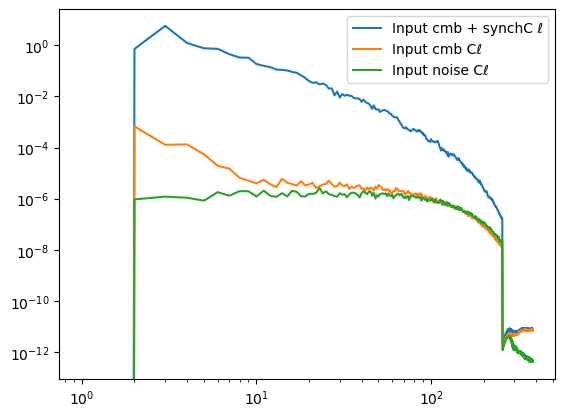

== (generic function with 267 methods)

In [ ]:
#==
set_params.nside = 128
nside = 128
lmax = 2nside
npix = hp.nside2npix(nside)
fwhm_con = 69
base_dir = "/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/make_map/fg_map_make/fg_map/"
nside_str = "_nside_$(nside)"
seed_name = "_seed_"
seed_n = string(set_params.seed)
GHz = "_GHz"
Synch_name = joinpath(base_dir, "Synch_$(40)$(GHz)$(nside_str)")
synch_data = hp.read_map(Synch_name, field=(0,1,2))
synch_data = py"bandpass_map"(synch_data, set_params.nside, lmin, lmax)
smoothed_data_synch = smoothing_map_fwhm(synch_data, fwhm_con, set_params.nside)
cl_synch = hp.anafast(smoothed_data_synch)
base_dir_cmb = "/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/make_map/cmb_map_make/cmb_map3/"
r_name = "r_"
r_n = string(set_params.r_input)
Cmb_name = joinpath(base_dir_cmb, "$(r_name)$(r_n)$(nside_str)$(seed_name)$(seed_n)")
cmb_data = hp.read_map(Cmb_name, field=(0,1,2))
cmb_data = py"bandpass_map"(cmb_data, set_params.nside, lmin, lmax)
smoothed_cmb_data = smoothing_map_fwhm(cmb_data, fwhm_con, set_params.nside)
cl_cmb = hp.anafast(smoothed_cmb_data)
#cl_in = hp.anafast([set_params.m_set[1][1:npix], set_params.m_set[1][1:npix], set_params.m_set[1][1+npix:2npix]])
#plt.loglog(abs.(cl_in[3, :]), label="Input Cℓ")
plt.loglog(abs.(cl_cmb[3, :] + cl_synch[3, :]), label="Input cmb + synchC ℓ")
plt.loglog(abs.(cl_cmb[3, :]), label="Input cmb Cℓ")
plt.loglog(abs.(cl_noise[3, :]), label="Input noise Cℓ")
plt.legend()
==#

### confirm calculation speed

In [3]:
D_list = D_list_set(set_params, fit_params);

In [4]:
calc_DᵀN⁻¹D(set_params, cholesky_terms, D_list);
#cond(calc_DᵀN⁻¹D(set_params, cholesky_terms, D_list))

In [5]:
calc_DᵀN⁻¹Dcmb(set_params, matrix_terms, D_list);

In [6]:
calc_DᵀN⁻¹m(set_params, matrix_terms, D_list);

In [7]:
calc_A(set_params, fit_params, cholesky_terms, matrix_terms);

In [8]:
calc_B(cholesky_terms);

In [9]:
calc_mN⁻¹DcmbA⁻¹DcmbᵀN⁻¹m(set_params);

In [10]:
calc_MᵀHM_and_MᵀHB⁻¹HM(set_params, cholesky_terms, D_list);

In [11]:
cholesky_logdet(cholesky_terms.DᵀN⁻¹D_L);

### calculate likelihood

In [12]:
#@btime likelihood = calc_likelihood(set_params, fit_params, cholesky_terms)
likelihood = calc_likelihood(set_params, fit_params, cholesky_terms)

-1.5905924481840002e10

In [13]:
#@btime iterative_minimization(set_params, fit_params, cholesky_terms)
iterative_minimization(set_params, fit_params, cholesky_terms)

Iteration 1: r = 0.00952673013754124, Likelihood = -1.5905924750233303e10
delta_like = 2.5905924750233303e10
delta_r = 0.49047326986245876
Iteration 2: r = 0.009787285825092251, Likelihood = -1.5905924625795464e10
delta_like = 124.43783950805664
delta_r = 0.00026055568755101177
Iteration 3: r = 0.009787285825092251, Likelihood = -1.5905924627665138e10
delta_like = 1.8696746826171875
delta_r = 0.0
Iteration 4: r = 0.009785880983821382, Likelihood = -1.5905924627665142e10
delta_like = 3.814697265625e-6
delta_r = 1.4048412708689284e-6


In [ ]:
fit_params

In [121]:
num_seeds = 10
@time r_dis, beta_s_dis, beta_d_dis, T_d_dis = estimate_r_distribution_truncate(set_params, fit_params, cholesky_terms, num_seeds, lmin, lmax)

Iteration 1: r = 0.0022229978588621524, Likelihood = -1.8841343612675972e10
delta_like = 2.8841343612675972e10
delta_r = 0.014225337754527834
Iteration 2: r = 0.0018231937881942883, Likelihood = -1.884134358492837e10
delta_like = 27.747600555419922
delta_r = 0.00039980407066786405
Iteration 3: r = 0.0018065366995843046, Likelihood = -1.8841343583067257e10
delta_like = 1.861114501953125
delta_r = 1.6657088609983717e-5
Iteration 4: r = 0.0018065366995843046, Likelihood = -1.8841343583067257e10
delta_like = 0.0
delta_r = 0.0
Iteration 1: r = 0.009609576057075575, Likelihood = -1.8846341454511726e10
delta_like = 2.8846341454511726e10
delta_r = 0.006838759556314411
Iteration 2: r = 0.009553087850108, Likelihood = -1.8846341456965313e10
delta_like = 2.4535865783691406
delta_r = 5.6488206967575394e-5
Iteration 3: r = 0.009553087850108, Likelihood = -1.8846341450543213e10
delta_like = 6.422100067138672
delta_r = 0.0
Iteration 4: r = 0.009583692811125921, Likelihood = -1.8846341448135773e10
del

(Any[0.0018065366995843046, 0.009583692811125921, 0.0056997639515088405, 0.009538713517361908, 0.012518562892201546, 0.011400594146302234, 0.008948333875981485, 0.009113861846395732, 0.006432656864430619, 0.009099188753095788], Any[-3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0, -3.0], Any[1.4970570951474755, 1.553499663554843, 1.4691987466618677, 1.5210026211040166, 1.5538978144735105, 1.5258641092647398, 1.500259405421915, 1.5315329342797317, 1.4714739902022733, 1.5259381025438499], Any[17.42753859685137, 18.48423875354077, 16.625452382013464, 17.99411771834523, 18.407364302648066, 17.339414857701907, 16.748783129705558, 17.072050266682, 17.02280746441414, 17.179832655558776])

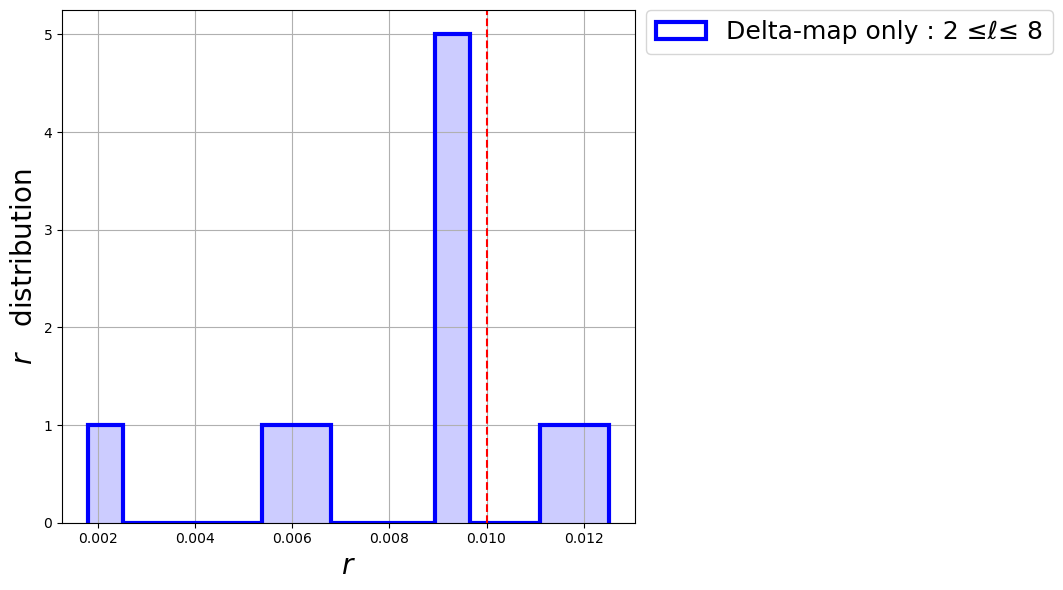

In [123]:
figure(figsize=(8, 6))
hist(r_dis, bins=15, alpha=0.2, color="blue", histtype="stepfilled")
hist(r_dis, bins = 15, alpha = 1., edgecolor = "blue", label = "Delta-map only : 2 ≤ℓ≤ 8", histtype = "step", linewidth = 3)
axvline(x = r_input, color = "red", linestyle = "--")
xlabel(L"$r$", fontsize=20)
ylabel(L"$r\quad$distribution", fontsize=20) 
plt.grid(true)
legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize="18")
tight_layout()
subplots_adjust(right=0.8)
show() 

In [124]:
println(mean(r_dis))
println(std(r_dis))

0.008414190535798838
0.0030658787877907933


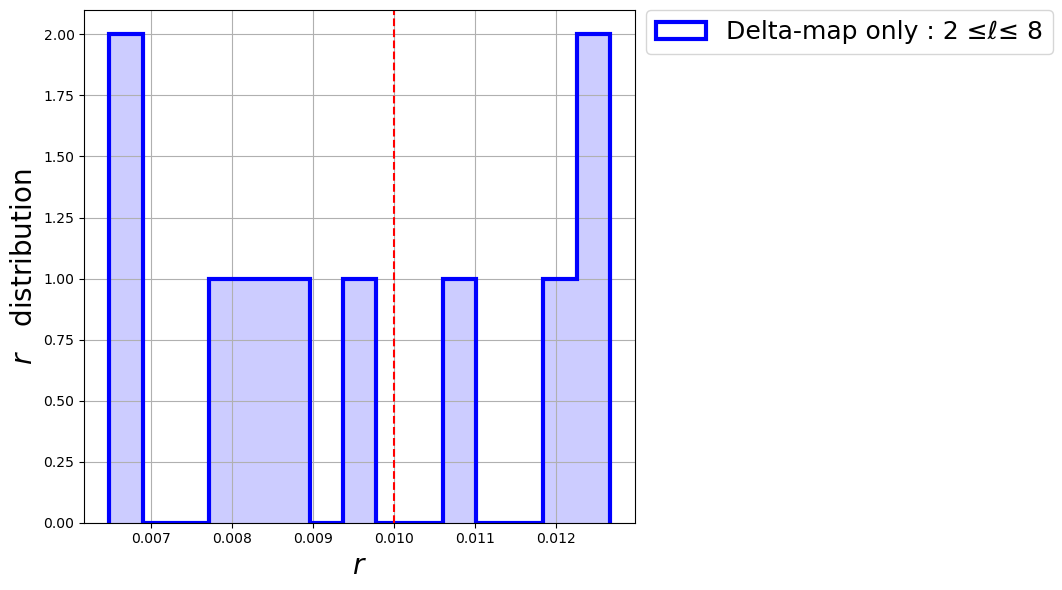

In [93]:
figure(figsize=(8, 6))
hist(r_dis, bins=15, alpha=0.2, color="blue", histtype="stepfilled")
hist(r_dis, bins = 15, alpha = 1., edgecolor = "blue", label = "Delta-map only : 2 ≤ℓ≤ 8", histtype = "step", linewidth = 3)
axvline(x = r_input, color = "red", linestyle = "--")
xlabel(L"$r$", fontsize=20)
ylabel(L"$r\quad$distribution", fontsize=20) 
plt.grid(true)
legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize="18")
tight_layout()
subplots_adjust(right=0.8)
show()

In [16]:
mean(r_dis)

0.008967962117251971

In [20]:
using PyCall
hp = pyimport("healpy")

x = 2:1:4
y = 2 .^x;
mask_num_list = []

for nside_i in Int.(y)
    mask_path = "../../P06_nside_$(nside_i).fits"
    mask = hp.read_map(mask_path) 
    push!(mask_num_list, sum(mask .== 0))
end

In [27]:
num_pix

3-element Vector{Int64}:
  214
  948
 4144

In [22]:
num_pix = 2*(12y .^2 .- mask_num_list)
num_ell = 2*(2y.-1).*(2y.+3);

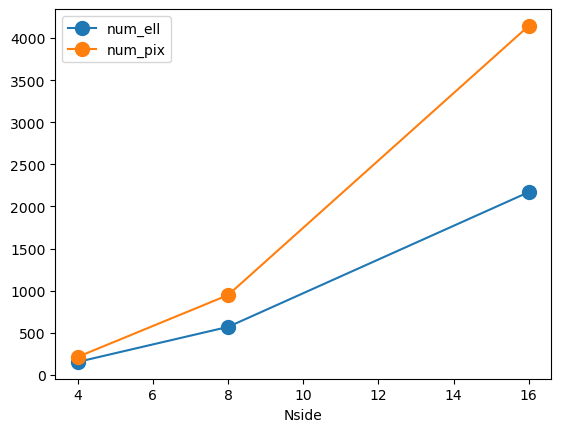

PyObject <matplotlib.legend.Legend object at 0x32f357b60>

In [29]:
using PyPlot
# plt.plot(y, (num_ell ./ num_pix) .^ 0.5, "o-")
plt.plot(y, num_ell, "o-", label = "num_ell", markersize = 10)
plt.plot(y, num_pix, "o-", label = "num_pix", markersize = 10)
plt.xlabel("Nside")
plt.legend()

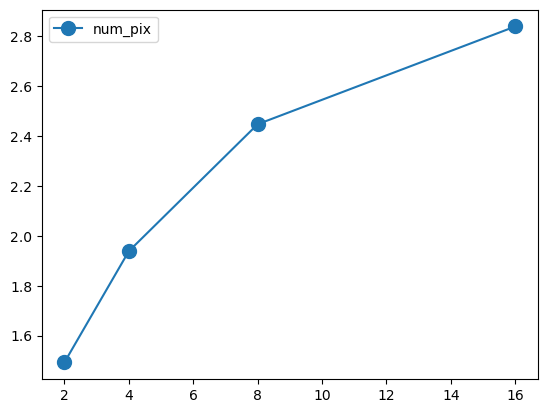

PyObject <matplotlib.legend.Legend object at 0x31320a150>

In [ ]:
using PyPlot
# plt.plot(y, (num_ell ./ num_pix) .^ 0.5, "o-")
#plt.loglog(y, (num_ell).^3, "o-", label = "num_ell", markersize = 10)
#plt.loglog(y, (num_pix/2).^3, "o-", label = "num_pix", markersize = 10)
plt.plot(y, (num_pix ./ num_ell).^3, "o-", label = "num_pix", markersize = 10)
plt.legend()

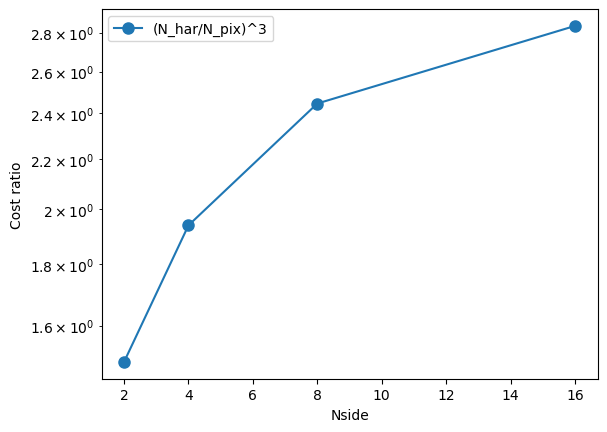

PyObject <matplotlib.legend.Legend object at 0x313f245f0>

In [41]:
x = 1:1:4
y = 2 .^ x
num_pix = 12y .^2 
num_ell = 2*(2y.-1).*(2y.+3);
cost_ratio = (num_pix ./ num_ell) .^ 3

using PyPlot
plt.plot(y, cost_ratio, "o-", label="(N_har/N_pix)^3", markersize=8)
plt.yscale("log")
plt.xlabel("Nside")
plt.ylabel("Cost ratio")
plt.legend()


In [39]:
using Healpix
using PyPlot

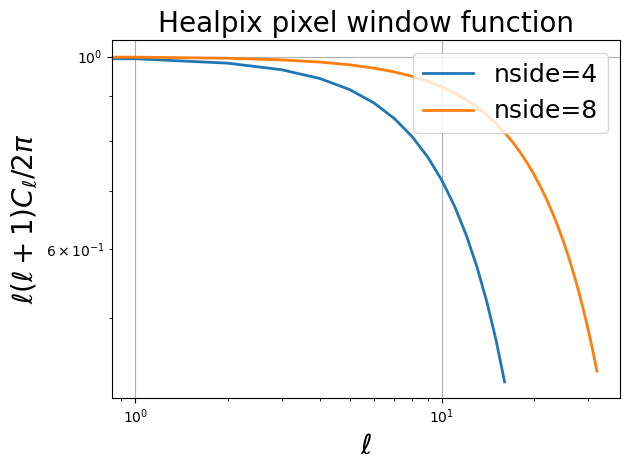

In [81]:
wl_4 = pixwin(4, pol=true)
wl_8 = pixwin(8, pol=true)

plt.loglog(wl_4[1], label = "nside=4", linewidth = 2)
plt.loglog(wl_8[1], label = "nside=8", linewidth = 2)
plt.xlabel(L"$\ell$", fontsize=20)
plt.ylabel(L"$\ell(\ell+1)C_\ell/2\pi$", fontsize=20)
plt.legend(loc="upper right", fontsize=18)
plt.grid(true)
plt.title("Healpix pixel window function", fontsize=20)
plt.tight_layout()
plt.show()